In [1]:
import pandas as pd
from semnet import SemanticNetwork
import numpy as np
from sentence_transformers import SentenceTransformer

/home/ian/Projects/semnet/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
names = [
    "Tony Blair",
    "Anthony Blair",
    "Sir Tony Blair",
    "Barack H. Obama",
    "Barack Obama",
    "Donald J. Trump",
    "Donald Trump",
    "The Donald",
    "Elon Musk",
    "Joe Biden",
    "Joseph Biden"
]

semnet = SemanticNetwork(thresh=0.2, verbose=True)
representatives = semnet.fit_transform(names)
print("Representatives:")
for rep in representatives:
    print(f"- {rep}")
semnet.get_duplicate_groups()

Finding similarities: 100%|██████████| 11/11 [00:00<00:00, 51898.02it/s]

Representatives:
- Tony Blair
- Barack H. Obama
- Donald J. Trump
- Elon Musk
- Joe Biden


[['Tony Blair', 'Anthony Blair', 'Sir Tony Blair'],
 ['Donald J. Trump', 'Donald Trump', 'The Donald'],
 ['Barack H. Obama', 'Barack Obama'],
 ['Joe Biden', 'Joseph Biden']]

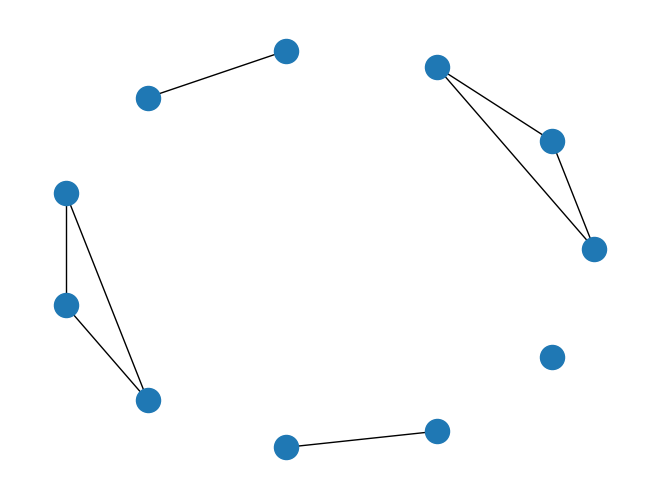

In [26]:
import networkx as nx

nx.draw_circular(semnet.graph_)

In [20]:
url = "https://github.com/MarkHershey/CompleteTrumpTweetsArchive/raw/refs/heads/master/data/realDonaldTrump_in_office.csv"
df = pd.read_csv(url)
print(df.head(5))

ParserError: Error tokenizing data. C error: Expected 4 fields in line 3, saw 5


In [2]:
# Load the test dataset
df = pd.read_csv("test_data.csv")
ground_truth = pd.read_csv("ground_truth.csv")

print(f"Dataset overview:")
print(f"Total records: {len(df)}")
print(f"Ground truth matches: {len(ground_truth)}")
print(f"\nSample records:")
print(df.head())

Dataset overview:
Total records: 302
Ground truth matches: 300

Sample records:
   id                          name      organisation
0   1                    Tony Blair      Labour Party
1   2                Sir Tony Blair      Labour Party
2   3  Anthony Charles Lynton Blair      Labour Party
3   4                  Donald Trump  Republican Party
4   5                Donald J Trump  Republican Party


In [3]:
def evaluate_accuracy(predicted_mapping, ground_truth_df, df):
    """
    Evaluate the accuracy of semantic deduplication against ground truth.

    Args:
        predicted_mapping: Dict mapping duplicate IDs to representative IDs
        ground_truth_df: DataFrame with ground truth matches
        df: Original data DataFrame with id, name, organisation

    Returns:
        Dict with precision, recall, f1_score, and detailed metrics
    """
    # Convert ground truth to set of pairs (ensuring consistent ordering)
    gt_pairs = set()
    for _, row in ground_truth_df.iterrows():
        pair = tuple(sorted([row["id1"], row["id2"]]))
        gt_pairs.add(pair)

    # Convert predicted mapping to pairs
    predicted_pairs = set()

    # Group by representative to find all documents that should be together
    rep_groups = {}
    for dup_id, rep_id in predicted_mapping.items():
        if rep_id not in rep_groups:
            rep_groups[rep_id] = [rep_id]  # Include the representative itself
        rep_groups[rep_id].append(dup_id)

    # Generate all pairs within each group
    for rep_id, group in rep_groups.items():
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                pair = tuple(sorted([group[i], group[j]]))
                predicted_pairs.add(pair)

    # Calculate metrics
    true_positives = len(gt_pairs & predicted_pairs)
    false_positives = len(predicted_pairs - gt_pairs)
    false_negatives = len(gt_pairs - predicted_pairs)

    precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )
    f1_score = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "predicted_pairs_count": len(predicted_pairs),
        "ground_truth_pairs_count": len(gt_pairs),
    }

In [4]:
# Test semantic deduplication at various thresholds
names = df["name"].tolist()
embeddings = embedding_model.encode(names)
thresholds = range(0, 50, 5)
results = []

print("🔬 Testing semantic deduplication at various similarity thresholds...\n")

for thresh in thresholds:
    thresh = thresh / 100.0  # Convert to decimal
    print(f"🎯 Testing threshold: {thresh}")

    # Create semantic network (using fast model for demo)
    network = SemanticNetwork(
        docs=names,
        embeddings=embeddings,
        verbose=False,  # Keep output clean
    )

    # Run deduplication
    result = network.deduplicate_documents(thresh=thresh)

    # Evaluate against ground truth
    metrics = evaluate_accuracy(result["mapping"], ground_truth, df)

    # Store results
    result_summary = {
        "threshold": thresh,
        "original_count": result["stats"]["original_count"],
        "deduplicated_count": result["stats"]["deduplicated_count"],
        "reduction_ratio": result["stats"]["reduction_ratio"],
        "similarity_pairs": result["stats"]["similarity_pairs"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1_score": metrics["f1_score"],
        "true_positives": metrics["true_positives"],
        "false_positives": metrics["false_positives"],
        "false_negatives": metrics["false_negatives"],
    }
    results.append(result_summary)

    print(
        f"  📊 {result['stats']['original_count']} → {result['stats']['deduplicated_count']} records ({result['stats']['reduction_ratio']:.1%} reduction)"
    )
    print(
        f"  🎯 Precision: {metrics['precision']:.3f} | Recall: {metrics['recall']:.3f} | F1: {metrics['f1_score']:.3f}"
    )
    print(
        f"  ✅ TP: {metrics['true_positives']} | ❌ FP: {metrics['false_positives']} | 🚫 FN: {metrics['false_negatives']}"
    )
    print()

🔬 Testing semantic deduplication at various similarity thresholds...

🎯 Testing threshold: 0.0
  📊 302 → 1 records (99.7% reduction)
  🎯 Precision: 0.007 | Recall: 0.993 | F1: 0.013
  ✅ TP: 298 | ❌ FP: 45153 | 🚫 FN: 2

🎯 Testing threshold: 0.05
  📊 302 → 1 records (99.7% reduction)
  🎯 Precision: 0.007 | Recall: 0.993 | F1: 0.013
  ✅ TP: 298 | ❌ FP: 45153 | 🚫 FN: 2

🎯 Testing threshold: 0.1
  📊 302 → 5 records (98.3% reduction)
  🎯 Precision: 0.007 | Recall: 0.940 | F1: 0.013
  ✅ TP: 282 | ❌ FP: 41635 | 🚫 FN: 18

🎯 Testing threshold: 0.15
  📊 302 → 18 records (94.0% reduction)
  🎯 Precision: 0.008 | Recall: 0.783 | F1: 0.015
  ✅ TP: 235 | ❌ FP: 30957 | 🚫 FN: 65

🎯 Testing threshold: 0.2
  📊 302 → 58 records (80.8% reduction)
  🎯 Precision: 0.072 | Recall: 0.433 | F1: 0.123
  ✅ TP: 130 | ❌ FP: 1684 | 🚫 FN: 170

🎯 Testing threshold: 0.25
  📊 302 → 90 records (70.2% reduction)
  🎯 Precision: 0.143 | Recall: 0.340 | F1: 0.202
  ✅ TP: 102 | ❌ FP: 610 | 🚫 FN: 198

🎯 Testing threshold: 0.3
  

In [5]:
# Create results DataFrame for analysis
results_df = pd.DataFrame(results)

print("📈 SUMMARY OF RESULTS ACROSS THRESHOLDS")
print("=" * 80)
print(
    results_df[
        [
            "threshold",
            "deduplicated_count",
            "reduction_ratio",
            "precision",
            "recall",
            "f1_score",
        ]
    ].round(3)
)

print(f"\n🏆 BEST PERFORMING THRESHOLD:")
best_f1 = results_df.loc[results_df["f1_score"].idxmax()]
print(f"Threshold: {best_f1['threshold']}")
print(f"F1-Score: {best_f1['f1_score']:.3f}")
print(f"Precision: {best_f1['precision']:.3f}")
print(f"Recall: {best_f1['recall']:.3f}")
print(
    f"Reduction: {best_f1['reduction_ratio']:.1%} ({best_f1['original_count']} → {best_f1['deduplicated_count']} records)"
)

📈 SUMMARY OF RESULTS ACROSS THRESHOLDS
   threshold  deduplicated_count  reduction_ratio  precision  recall  f1_score
0       0.00                   1            0.997      0.007   0.993     0.013
1       0.05                   1            0.997      0.007   0.993     0.013
2       0.10                   5            0.983      0.007   0.940     0.013
3       0.15                  18            0.940      0.008   0.783     0.015
4       0.20                  58            0.808      0.072   0.433     0.123
5       0.25                  90            0.702      0.143   0.340     0.202
6       0.30                 118            0.609      0.264   0.263     0.264
7       0.35                 151            0.500      0.261   0.177     0.211
8       0.40                 167            0.447      0.234   0.137     0.173
9       0.45                 187            0.381      0.206   0.097     0.132

🏆 BEST PERFORMING THRESHOLD:
Threshold: 0.3
F1-Score: 0.264
Precision: 0.264
Recall: 0.263


In [8]:
# Detailed analysis of the best threshold
ids = df["id"].tolist()
# best_threshold = best_f1["threshold"]
best_threshold = 0.4
print(f"\n🔍 DETAILED ANALYSIS AT OPTIMAL THRESHOLD ({best_threshold})")
print("=" * 60)

# Run deduplication again with best threshold and verbose output
network_best = SemanticNetwork(docs=names, embeddings=embeddings, verbose=True)

result_best = network_best.deduplicate_documents(thresh=best_threshold)

print(f"\n📋 Sample duplicate groups found:")
groups = network_best.get_duplicate_groups()
for i, group in enumerate(groups[:5], 1):  # Show first 5 groups
    print(f"\nGroup {i} ({len(group)} items):")
    for name in group:
        doc_idx = names.index(name)
        record_id = ids[doc_idx]
        is_representative = doc_idx not in result_best["mapping"]
        marker = "👑" if is_representative else "  "
        print(f"  {marker} ID {record_id}: {name}")

print(f"\n🎯 Key test cases:")
# Check Donald Trump vs Donald Trump Jr
trump_ids = [4, 5, 6]  # Donald Trump variants
trump_jr_ids = [7, 8]  # Donald Trump Jr variants

trump_mapped = [result_best["mapping"].get(i, i) for i in trump_ids]
trump_jr_mapped = [result_best["mapping"].get(i, i) for i in trump_jr_ids]

print(f"Donald Trump variants (IDs {trump_ids}) → Representatives: {set(trump_mapped)}")
print(
    f"Donald Trump Jr variants (IDs {trump_jr_ids}) → Representatives: {set(trump_jr_mapped)}"
)

if (
    len(set(trump_mapped)) == 1
    and len(set(trump_jr_mapped)) == 1
    and set(trump_mapped) != set(trump_jr_mapped)
):
    print("✅ PASS: Trump and Trump Jr correctly identified as different people")
else:
    print("❌ FAIL: Trump and Trump Jr incorrectly merged or not properly clustered")


🔍 DETAILED ANALYSIS AT OPTIMAL THRESHOLD (0.4)


Finding similarities: 100%|██████████| 302/302 [00:00<00:00, 19714.86it/s]


📋 Sample duplicate groups found:

Group 1 (3 items):
  👑 ID 4: Donald Trump
     ID 5: Donald J Trump
     ID 6: Donald John Trump

Group 2 (3 items):
  👑 ID 9: Joe Biden
     ID 10: Joseph Biden
     ID 11: Joseph R Biden

Group 3 (3 items):
  👑 ID 12: Barack Obama
     ID 13: Barack H Obama
     ID 14: Barack Hussein Obama

Group 4 (3 items):
     ID 15: Hillary Clinton
     ID 16: Hillary Rodham Clinton
  👑 ID 17: Hillary R Clinton

Group 5 (3 items):
  👑 ID 21: Emmanuel Macron
     ID 22: Emmanuel Jean-Michel Frédéric Macron
     ID 23: E Macron

🎯 Key test cases:
Donald Trump variants (IDs [4, 5, 6]) → Representatives: {3, 6}
Donald Trump Jr variants (IDs [7, 8]) → Representatives: {8, 6}
❌ FAIL: Trump and Trump Jr incorrectly merged or not properly clustered
